In [57]:
import numpy as np
import pandas as pd 
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from tqdm.notebook import tqdm
from datetime import datetime as dt

### Классический бутстрап  разницы средних
1. Подвыборки
2. Разница средних
3. Дисперсия из разницы средних
4. Расчёт pvalue, как 1 - функция распределения, распределенная нормально (по ЦПТ, средние). Двусторонняя гипотеза - $ 2 * (1 - F_x) $ , где  $ F_x $ - функция распределения случайной величины 

In [25]:
def classic_bootstrap(a, b, num_experiments = 1000):
    num_experiments = 1000
    delta_means = []
    for exp in range(num_experiments):
        a_boots = np.random.choice(a, len(a), replace = True)
        b_boots = np.random.choice(b, len(b), replace = True)
        delta_mean = np.mean(b_boots) - np.mean(a_boots)
        delta_means.append(delta_mean)

    std_delta_means = np.std(delta_means)
    true_delta = np.mean(b) - np.mean(a)
    return 2 * (1 - stats.norm.cdf(np.abs(true_delta / std_delta_means)))

# рассмотрим двухстороннюю гипотезу

__Стандартное нормальное распределение__
$ X1, X2, ... Xn \sim N(0,1) $

  0%|          | 0/1000 [00:00<?, ?it/s]

Время выполнения: 0:01:40.838113


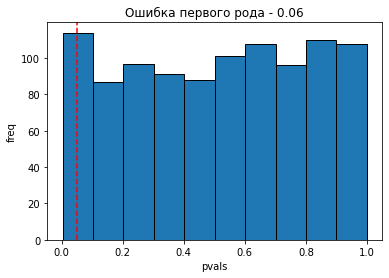

In [59]:
now = dt.now() 
pvals = [classic_bootstrap(a = np.random.normal(0,1, size = 1000), b = np.random.normal(0,1, size = 1000)) for i in tqdm(range(1000))]

plt.hist(pvals, edgecolor = 'black')
plt.xlabel('pvals')
plt.ylabel('freq')
plt.title(f'Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.axvline(0.05, linestyle = '--', color = 'red')

after = dt.now()

print(f'Время выполнения: {str(after - now)}')

Границы применимости Bootstrap для разницы средних (поиск крайней точки эмпирически в которых ошибка первого рода еще находится на уровне ${a}$), распределение ${p-value}$ равномерное

0it [00:00, ?it/s]

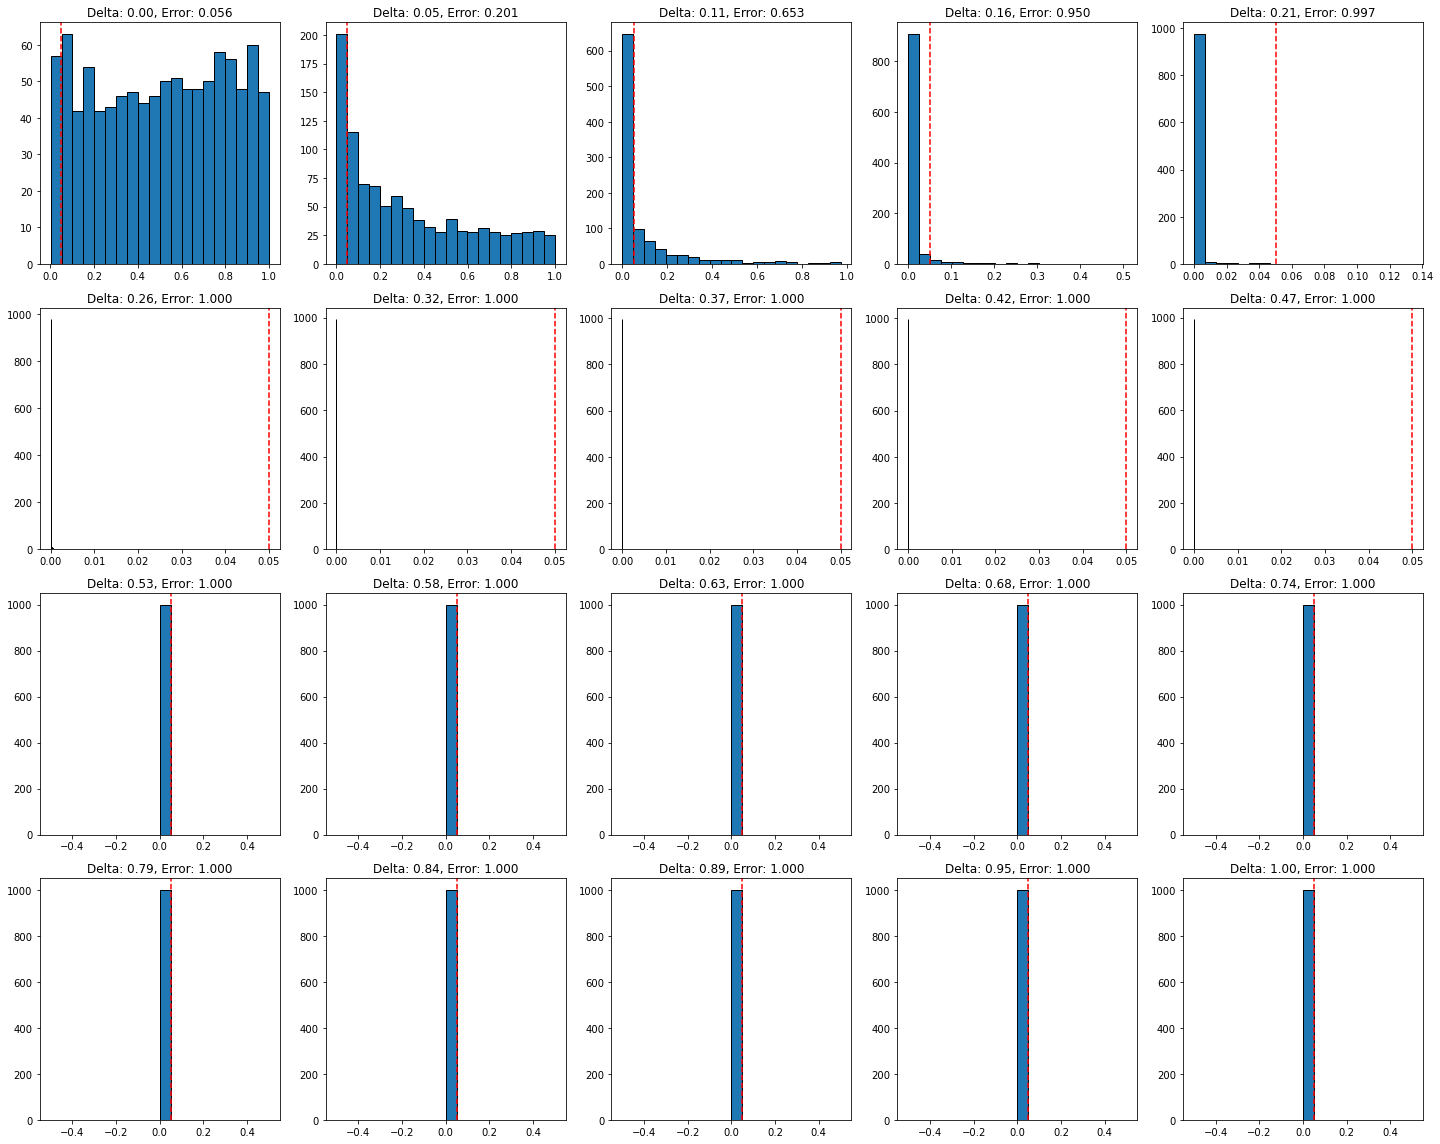

Время выполнения: 0:35:33.820529


In [60]:
num_experiments = 1000
num_graphs = 20
delta_values = np.linspace(0, 1, num_graphs)
now = dt.now() 

fig, axes = plt.subplots(4, 5, figsize=(20, 16))  
errors_first_type = []

for i, delta in tqdm(enumerate(delta_values)):
    pvals = [classic_bootstrap(a=np.random.normal(0, 1, size=1000),
                               b=np.random.normal(delta, 1, size=1000))
             for _ in range(num_experiments)]
    errors_first_type.append(np.mean(np.array(pvals) < 0.05))
    
    ax = axes[i // 5, i % 5]
    ax.hist(pvals, bins=20, edgecolor='black')
    ax.set_title(f'Delta: {delta:.2f}, Error: {errors_first_type[-1]:.3f}')
    ax.axvline(0.05, linestyle='--', color='red')

plt.tight_layout()
plt.show()

after = dt.now()

print(f'Время выполнения: {after - now}')

5% дает скошенное распределение **pvalue**, причем после 0.5 с вероятностью 1 нулевая гипотеза о равенстве средних отвергается, даже delta = 0.2 уже дает вероятность около **1** отвержения нулевой гипотезы

0it [00:00, ?it/s]

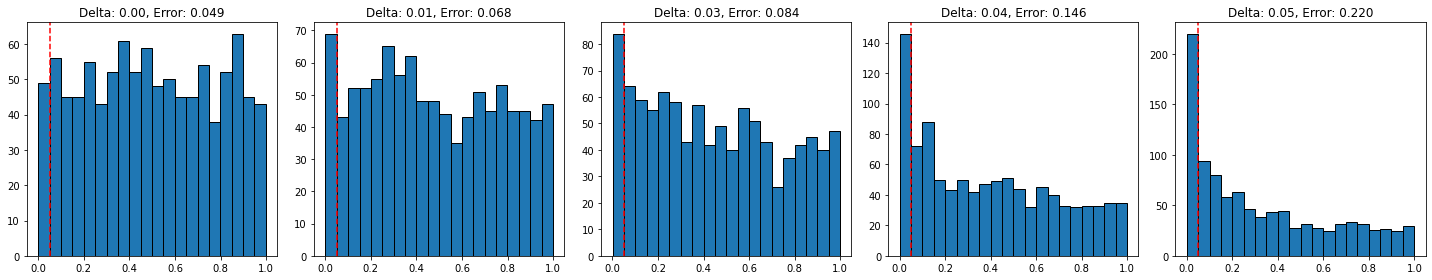

Время выполнения: 0:07:55.546536


In [63]:
num_experiments = 1000
num_graphs = 5
delta_values = np.linspace(0, 0.05, num_graphs)
now = datetime.now()

fig, axes = plt.subplots(1, num_graphs, figsize=(20, 4))  
errors_first_type = []

for i, delta in tqdm(enumerate(delta_values)):
    pvals = [classic_bootstrap(a=np.random.normal(0, 1, size=1000),
                               b=np.random.normal(delta, 1, size=1000))
             for _ in range(num_experiments)]
    errors_first_type.append(np.mean(np.array(pvals) < 0.05))
    
    axes[i].hist(pvals, bins=20, edgecolor='black')
    axes[i].set_title(f'Delta: {delta:.2f}, Error: {errors_first_type[-1]:.3f}')
    axes[i].axvline(0.05, linestyle='--', color='red')

plt.tight_layout()
plt.show()

after = datetime.now()

print(f'Время выполнения: {after - now}')

1% delta еще даёт +- адекватное распределение pvalue для ошибки первого рода, дальше - мы уже рассматриваем ошибку второго рода, после delta = 4%. Это эмпирический подход, для выборки можно рассчитать MDE, который мы можем наблюдать при заданных
1. $ \alpha $
2. $ \beta $
3. **sample_size**
4. **std**

In [75]:
def get_mde(a, b, alpha=0.05, beta=0.2):
    n_a, n_b = len(a), len(b)
    sigma_a, sigma_b = np.std(a, ddof=1), np.std(b, ddof=1)
    Q = stats.norm.ppf(1 - alpha / 2) + stats.norm.ppf(1 - beta)
    MDE = Q * np.sqrt(sigma_a**2 / n_a + sigma_b**2 / n_b)
    return MDE


In [77]:
a = np.random.normal(0, 1, size=1000)
b = np.random.normal(0, 1, size=1000)
mde_test = get_mde(a, b)
pvals = [classic_bootstrap(a=np.random.normal(0, 1, size=1000),
                               b=np.random.normal(0 + mde_test, 1, size=1000))
             for _ in range(num_experiments)]

Text(0.5, 1.0, 'Power = 0.786, mde = 0.13')

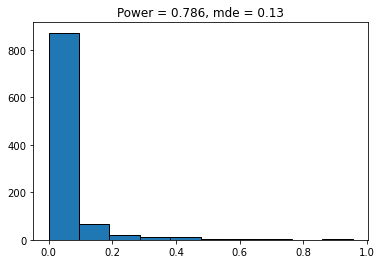

In [87]:
plt.hist(pvals, edgecolor = 'black')
plt.title(f"Power = {np.mean(np.array(pvals) < 0.05)}, mde = {np.round(mde_test,2)}")

# между delta 0.11 и 0.16 как раз находится эффект, благодаря которому мы можем с определенной уверенностью наблюдать 
# за изменениями

ПО ЦПТ распределение средних, а также их разница по свойству линейности матожиданий, будет давать также нормальное распределение. Поэтому для любых распределений это может быть применимо.

Рассмотрим $ X1, X2, ... Xn \sim exp(0,1) $

  0%|          | 0/1000 [00:00<?, ?it/s]

Время выполнения: 0:01:32.406953


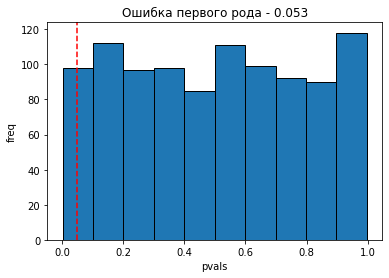

In [90]:
now = dt.now() 
pvals = [classic_bootstrap(a = np.random.exponential(1, size = 1000), b = np.random.exponential(1, size = 1000)) for i in tqdm(range(1000))]

plt.hist(pvals, edgecolor = 'black')
plt.xlabel('pvals')
plt.ylabel('freq')
plt.title(f'Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.axvline(0.05, linestyle = '--', color = 'red')

after = dt.now()

print(f'Время выполнения: {str(after - now)}')

In [95]:
a = np.random.exponential(1, size = 1000)
b = np.random.exponential(1, size = 1000)
mde_test = get_mde(a, b)
pvals = [classic_bootstrap(a=a,
                               b= np.random.exponential(1 + mde_test, size = 1000))
             for _ in tqdm(range(num_experiments))]


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Power = 0.801, mde = 0.13')

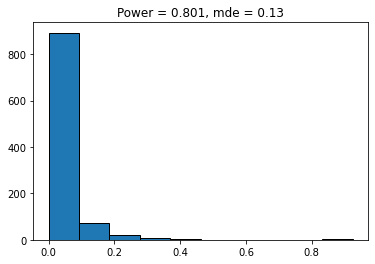

In [98]:
plt.hist(pvals, edgecolor = 'black')
plt.title(f"Power = {np.mean(np.array(pvals) < 0.05)}, mde = {np.round(mde_test,2)}")

### Бутстрап с разницей средних (доверительный интервал)

1. Подвыборки
2. Разница средних
3. Доверительный интервал для разницы средних. Если 0 попадает в доверительный интервал, значит разницы нет, если не попадает, то разница есть (обычно берется 95% доверительный интервал, разница между квантилями 97.5 и 2.5 квантилями)

In [102]:
num_experiments = 1000
delta_means = []
for exp in range(num_experiments):
    a_boots = np.random.choice(a, len(a), replace = True)
    b_boots = np.random.choice(b, len(b), replace = True)
    delta_mean = np.mean(b_boots) - np.mean(a_boots)
    delta_means.append(delta_mean)


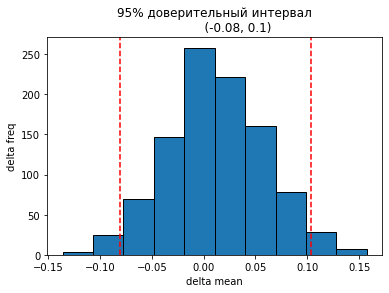

In [116]:
plt.hist(delta_means, edgecolor = 'black')
plt.title(f"""95% доверительный интервал
            {(np.round(np.quantile(delta_means, 0.025), 2), 
            np.round(np.quantile(delta_means, 0.975), 2))}""")
plt.xlabel('delta mean')
plt.ylabel('delta freq')
plt.axvline(np.quantile(delta_means, 0.025), color = 'r', linestyle = '--')
plt.axvline(np.quantile(delta_means, 0.975), color = 'r', linestyle = '--')

In [120]:
delta_means = np.array(delta_means)

In [125]:
np.count_nonzero(delta_means[(delta_means > np.quantile(delta_means, 0.025)) & (delta_means < np.quantile(delta_means, 0.975))])
# 95% наблюдений из 1000 попадают между квантилями, остальные 5% говорят, что разница есть.

950

__Рассмотрим случаи, когда 0 входит в доверительный интервал, чтобы рассчитать ошибку первого рода__

In [140]:
def bootstrap_delta_mean_ci(a,b, alpha = 0.95, num_experiments = 1000):
    delta_means = []
    for i, exp in enumerate(range(num_experiments)):
        a_boots = np.random.choice(a, len(a), replace = True)
        b_boots = np.random.choice(b, len(b), replace = True)
        delta_mean = np.mean(b_boots) - np.mean(a_boots)
        delta_means.append(delta_mean)
    return delta_means


In [142]:
bootstrap_delta_mean_ci(a, b)[0:5]

[-0.0641068159453263,
 -0.04872550676099208,
 0.018081147107587348,
 0.023805842478988204,
 0.016665376539746313]

In [148]:
TN = 0
FP = 0

for i in tqdm(range(1000)):
    res_bootstrap_delta_mean_ci = bootstrap_delta_mean_ci(a = np.random.normal(0,1,size=1000),
                            b = np.random.normal(0,1,size=1000))

    if (0 > np.quantile(res_bootstrap_delta_mean_ci, 0.025)) & ( 0 < np.quantile(res_bootstrap_delta_mean_ci, 0.975)):
        TN += 1 / len(res_bootstrap_delta_mean_ci)
    else:
        FP += 1 / len(res_bootstrap_delta_mean_ci)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [152]:
TN, FP
# более точный метод определения стат значимости, нужно смотреть на то, 
# как это работает с экспоненциальным (проблем не должно быть)

(0.9500000000000007, 0.05000000000000004)

__Экспоненциальное распределение__

In [153]:
TN = 0
FP = 0

for i in tqdm(range(1000)):
    res_bootstrap_delta_mean_ci = bootstrap_delta_mean_ci(a = np.random.exponential(1,size=1000),
                            b = np.random.exponential(1,size=1000))

    if (0 > np.quantile(res_bootstrap_delta_mean_ci, 0.025)) & ( 0 < np.quantile(res_bootstrap_delta_mean_ci, 0.975)):
        TN += 1 / len(res_bootstrap_delta_mean_ci)
    else:
        FP += 1 / len(res_bootstrap_delta_mean_ci)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [154]:
TN, FP
# меньшая точность, но работает тоже нормально, рассмотрим график для последнего семплирования

(0.9460000000000007, 0.05400000000000004)

In [161]:
(np.round(np.quantile(res_bootstrap_delta_mean_ci, 0.025), 2), 
            np.round(np.quantile(res_bootstrap_delta_mean_ci, 0.975), 2))

(-0.16, 0.03)

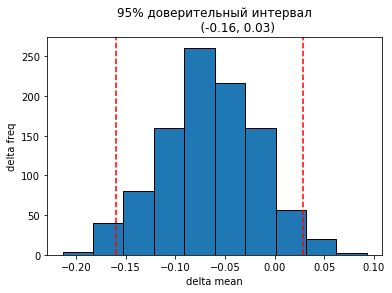

In [163]:
plt.hist(res_bootstrap_delta_mean_ci, edgecolor = 'black')
plt.title(f"""95% доверительный интервал
            {(np.round(np.quantile(res_bootstrap_delta_mean_ci, 0.025), 2), 
            np.round(np.quantile(res_bootstrap_delta_mean_ci, 0.975), 2))}""")
plt.xlabel('delta mean')
plt.ylabel('delta freq')
plt.axvline(np.quantile(res_bootstrap_delta_mean_ci, 0.025), color = 'r', linestyle = '--')
plt.axvline(np.quantile(res_bootstrap_delta_mean_ci, 0.975), color = 'r', linestyle = '--')

# высокая точность, все корректно, можно смотреть с лифтом

__c MDE экспоненциальное распределение__

In [172]:
# возьмем 2% дополнительно к MDE и рассмотрим на то, как меняется мощность на тех же данных

FN = 0
TP = 0

a = np.random.exponential(1,size=1000)
b = np.random.exponential(1,size=1000)
bias = np.random.normal(0,1 , size = 1000)
check_mde = get_mde(a, b)

for i in tqdm(range(1000)):
    res_bootstrap_delta_mean_ci = bootstrap_delta_mean_ci(a = np.random.exponential(1,size=1000),
                            b = np.random.exponential(1,size=1000) + check_mde)

    if (0 > np.quantile(res_bootstrap_delta_mean_ci, 0.025)) & ( 0 < np.quantile(res_bootstrap_delta_mean_ci, 0.975)):
        FN += 1 / len(res_bootstrap_delta_mean_ci)
    else:
        TP += 1 / len(res_bootstrap_delta_mean_ci)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [176]:
print('power')
print(TP)
print('type 2 error')
print(FN)

power
0.7870000000000006
type 2 error
0.21300000000000016


##### TP, FN, всё ок, примерно 80%, возьмем больший лифт

In [177]:
# возьмем 1% дополнительно к MDE и рассмотрим на то, как меняется мощность на тех же данных

FN = 0
TP = 0

a = np.random.exponential(1,size=1000)
b = np.random.exponential(1,size=1000)
bias = np.random.normal(0,1 , size = 1000)
check_mde = get_mde(a, b)

for i in tqdm(range(1000)):
    res_bootstrap_delta_mean_ci = bootstrap_delta_mean_ci(a = np.random.exponential(1,size=1000),
                            b = np.random.exponential(1,size=1000) + check_mde * 1.1)

    if (0 > np.quantile(res_bootstrap_delta_mean_ci, 0.025)) & ( 0 < np.quantile(res_bootstrap_delta_mean_ci, 0.975)):
        FN += 1 / len(res_bootstrap_delta_mean_ci)
    else:
        TP += 1 / len(res_bootstrap_delta_mean_ci)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [178]:
print('power')
print(TP)
print('type 2 error')
print(FN)

power
0.8650000000000007
type 2 error
0.1350000000000001


__Получили большую мощность, поэтому примерно между MDE и 10% находится значение Lift'а, которое соответствует power = 0.8__

__Рассмотрим логнормальное распределение с огромной дисперсией, посмотрим, будет ли чувствителен бутстрап к этому__

In [181]:
TN = 0
FP = 0

for i in tqdm(range(1000)):
    res_bootstrap_delta_mean_ci = bootstrap_delta_mean_ci(a = np.random.lognormal(100,20, size=1000),
                            b = np.random.lognormal(100, 20, size=1000))

    if (0 > np.quantile(res_bootstrap_delta_mean_ci, 0.025)) & ( 0 < np.quantile(res_bootstrap_delta_mean_ci, 0.975)):
        TN += 1 / len(res_bootstrap_delta_mean_ci)
    else:
        FP += 1 / len(res_bootstrap_delta_mean_ci)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [182]:
TN, FP
# большая дисперсия завышает FP на 7% от ожидаемого, вопрос, могут ли, например, ковариаты сократить её таким образом, чтобы
# ошибка первого рода была в пределах заданного alpha

(0.8740000000000007, 0.12600000000000008)

__Рассчитаем MDE для этого__

In [183]:
FN = 0
TP = 0

a = np.random.lognormal(100, 20, size=1000)
b = np.random.lognormal(100, 20, size=1000)
check_mde = get_mde(a, b)

for i in tqdm(range(1000)):
    res_bootstrap_delta_mean_ci = bootstrap_delta_mean_ci(a = np.random.lognormal(100, 20, size=1000),
                                                         b = np.random.lognormal(100 + check_mde, 20, size = 1000))

    if (0 > np.quantile(res_bootstrap_delta_mean_ci, 0.025)) & ( 0 < np.quantile(res_bootstrap_delta_mean_ci, 0.975)):
        FN += 1 / len(res_bootstrap_delta_mean_ci)
    else:
        TP += 1 / len(res_bootstrap_delta_mean_ci)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [186]:
FN, TP
# MDE становится слишком большим, из-за экстремальных значений мощность становится равна 100%, что логично.

(0, 1.0000000000000007)

### Пуассоновский бутстрап

1. Подвыборки
2. Генерация весов для каждого элемента из распределения пуассона
3. Расчет разницы взвешенных средних
4. Стандартное отклонение разницы средних
5. Расчет p-value как  $2 * (1 - {F_X})$)

  0%|          | 0/1000 [00:00<?, ?it/s]

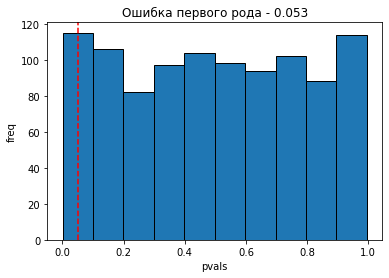

Время выполнения: 0:01:59.310127


In [221]:
def poisson_bootstrap(a, b, n=1000):
    
    weight_a_sum = np.zeros(n)
    weight_b_sum = np.zeros(n)
    weight_a_count = np.zeros(n)
    weight_b_count = np.zeros(n)

    for i in range(len(a)):
        weight = np.random.poisson(1, n)
        weight_a_sum += weight * a[i]
        weight_a_count += weight

    for i in range(len(b)):
        weight = np.random.poisson(1, n)
        weight_b_sum += weight * b[i]
        weight_b_count += weight
        
    diff_mean = weight_b_sum / weight_b_count - weight_a_sum / weight_a_count
    std_diff_mean = np.std(diff_mean)
    delta_mean = np.mean(b) - np.mean(a)

    return 2 * (1 - stats.norm.cdf(np.abs(delta_mean / std_diff_mean)))

now = datetime.now()
pvals = [poisson_bootstrap(a=np.random.normal(0, 1, size=1000),
                           b=np.random.normal(0, 1, size=1000))
         for _ in tqdm(range(1000))]

plt.hist(pvals, edgecolor='black')
plt.xlabel('pvals')
plt.ylabel('freq')
plt.title(f'Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.axvline(0.05, linestyle='--', color='red')
plt.show()

after = datetime.now()
print(f'Время выполнения: {str(after - now)}')


Время выполнения такое же, как и для классического бутстрапа, разница не было обнаружено.

__Посмотрим на чувствительность пуассоновского бутстрапа с MDE для N (100, 20)__

  0%|          | 0/1000 [00:00<?, ?it/s]

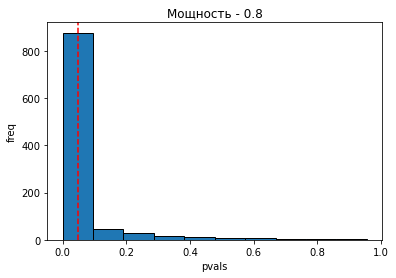

Время выполнения: 0:01:55.905128


In [226]:
a = np.random.normal(100, 20, size=1000)
b = np.random.normal(100, 20, size=1000)
check_mde = get_mde(a, b)

now = datetime.now()
pvals = [poisson_bootstrap(a=np.random.normal(100, 20, size=1000),
                           b=np.random.normal(100 + check_mde, 20, size=1000))
         for _ in tqdm(range(1000))]

plt.hist(pvals, edgecolor='black')
plt.xlabel('pvals')
plt.ylabel('freq')
plt.title(f'Мощность - {np.mean(np.array(pvals) < 0.05)}')
plt.axvline(0.05, linestyle='--', color='red')
plt.show()

after = datetime.now()
print(f'Время выполнения: {str(after - now)}')

# с мощностью всё в порядке, для нормального работает хорошо

In [228]:
check_mde

2.4708389794264

Проверка дельт для $\mu$, при использовании пуассоновского бутстрапа, для распределения - ${2.47}$

0it [00:00, ?it/s]

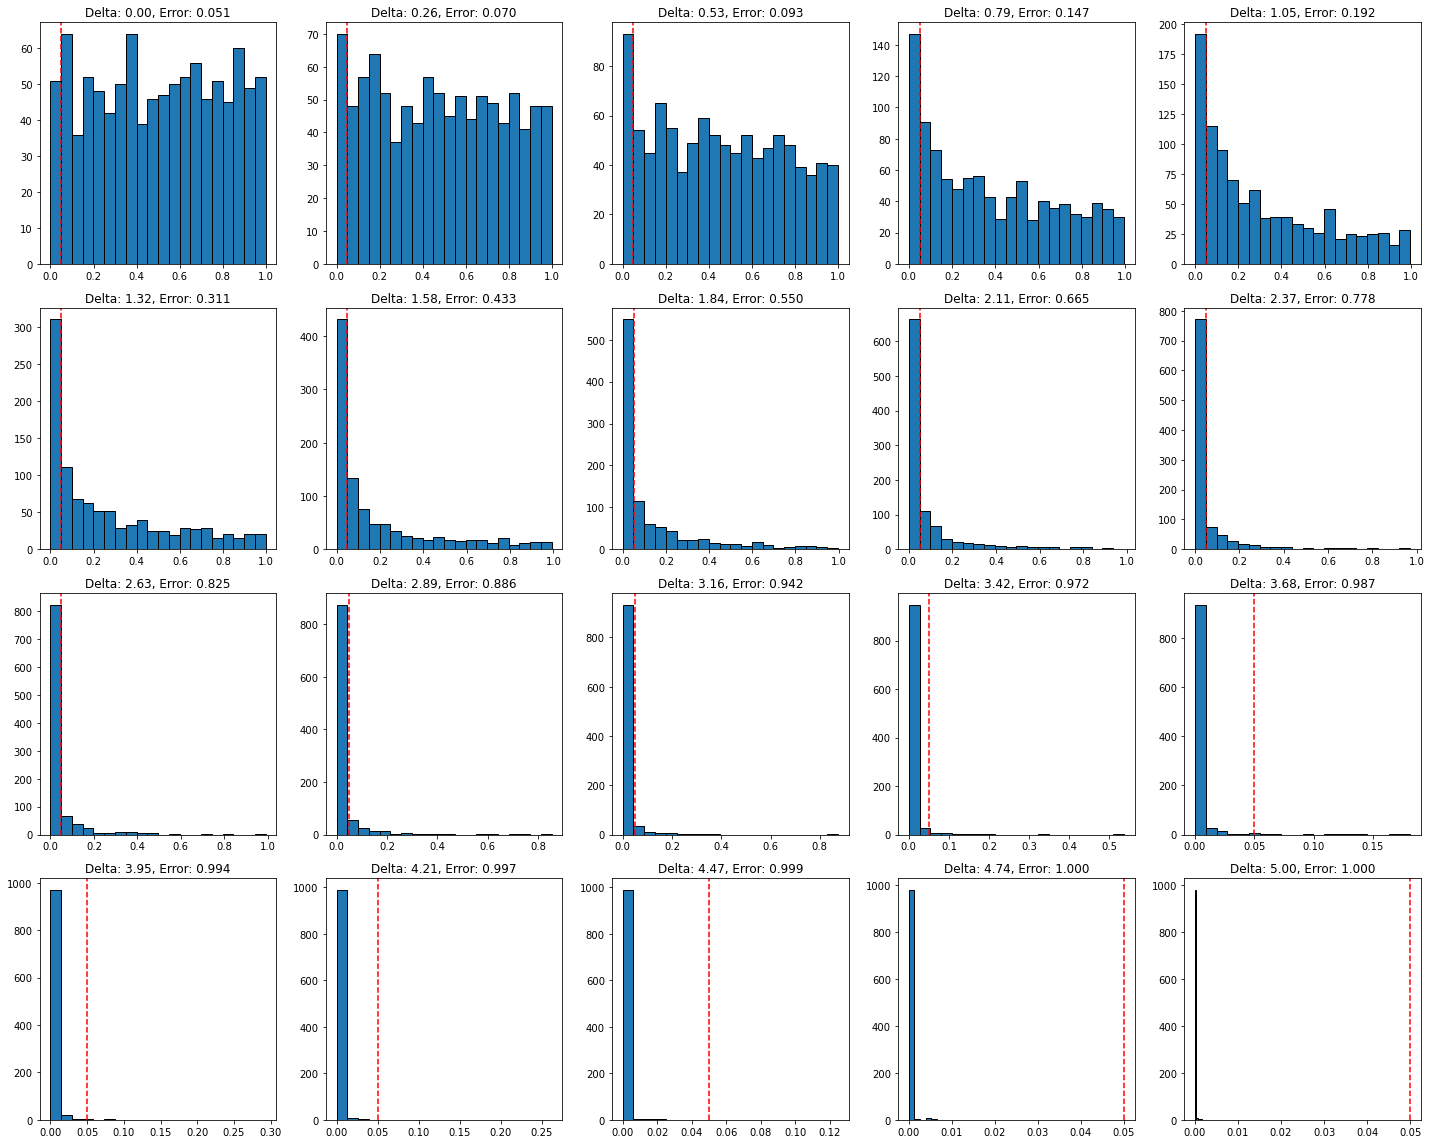

Время выполнения: 0:40:46.055843


In [232]:
num_experiments = 1000
num_graphs = 20
delta_values = np.linspace(0, 5, num_graphs)
now = dt.now() 

fig, axes = plt.subplots(4, 5, figsize=(20, 16))  
errors_first_type = []

for i, delta in tqdm(enumerate(delta_values)):
    pvals = [poisson_bootstrap(a=np.random.normal(100, 20, size=1000),
                               b=np.random.normal(100 + delta, 20, size=1000))
             for _ in range(num_experiments)]
    errors_first_type.append(np.mean(np.array(pvals) < 0.05))
    
    ax = axes[i // 5, i % 5]
    ax.hist(pvals, bins=20, edgecolor='black')
    ax.set_title(f'Delta: {delta:.2f}, Error: {errors_first_type[-1]:.3f}')
    ax.axvline(0.05, linestyle='--', color='red')

plt.tight_layout()
plt.show()

after = dt.now()

print(f'Время выполнения: {after - now}')

Ошибка второго рода становится, как теоретическая между разницей в Delta 2.37 и 2.63

__Предположим, что у нас данные распределены нормально, но есть проблемы с количеством наблюдений (их 30), посмотрим насколько будет меняться распределение pvalue__

0it [00:00, ?it/s]

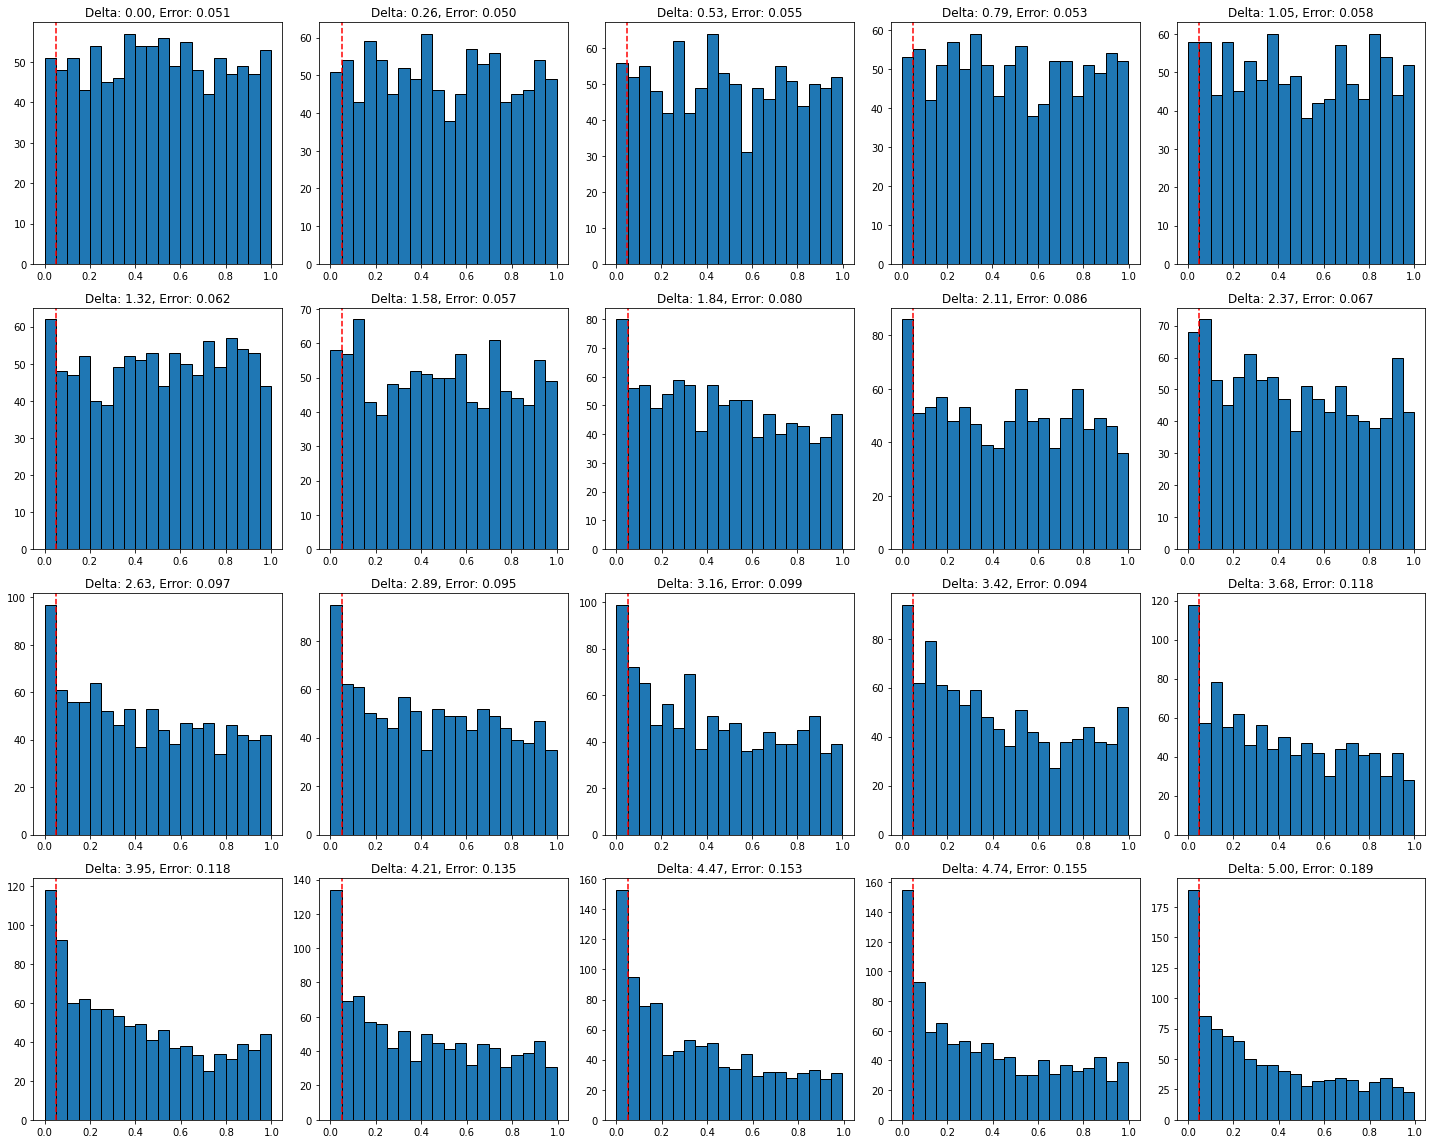

Время выполнения: 0:01:09.059904


In [233]:
num_experiments = 1000
num_graphs = 20
delta_values = np.linspace(0, 5, num_graphs)
now = dt.now() 

fig, axes = plt.subplots(4, 5, figsize=(20, 16))  
errors_first_type = []

for i, delta in tqdm(enumerate(delta_values)):
    pvals = [poisson_bootstrap(a=np.random.normal(100, 20, size=30),
                               b=np.random.normal(100 + delta, 20, size=30))
             for _ in range(num_experiments)]
    errors_first_type.append(np.mean(np.array(pvals) < 0.05))
    
    ax = axes[i // 5, i % 5]
    ax.hist(pvals, bins=20, edgecolor='black')
    ax.set_title(f'Delta: {delta:.2f}, Error: {errors_first_type[-1]:.3f}')
    ax.axvline(0.05, linestyle='--', color='red')

plt.tight_layout()
plt.show()

after = dt.now()

print(f'Время выполнения: {after - now}')

Как видно, ошибка граница допустимых значений ошибки первого рода сохраняется вплоть до delta = 1.58. Мы видим, что на delta = 5, ошибка первого рода = 0.2, хотя есть уже lift, рассчитаем ${mde}$

  0%|          | 0/1000 [00:00<?, ?it/s]

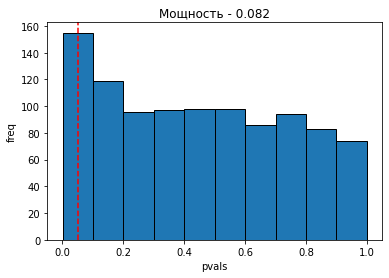

Время выполнения: 0:00:03.493188


In [235]:
a = np.random.normal(100, 20, size=1000)
b = np.random.normal(100, 20, size=1000)
check_mde = get_mde(a, b)

now = datetime.now()
pvals = [poisson_bootstrap(a=np.random.normal(100, 20, size=30),
                           b=np.random.normal(100 + check_mde, 20, size=30))
         for _ in tqdm(range(1000))]

plt.hist(pvals, edgecolor='black')
plt.xlabel('pvals')
plt.ylabel('freq')
plt.title(f'Мощность - {np.mean(np.array(pvals) < 0.05)}')
plt.axvline(0.05, linestyle='--', color='red')
plt.show()

after = datetime.now()
print(f'Время выполнения: {str(after - now)}')

# с мощностью всё в порядке, для нормального работает хорошо

Мощность достаточно низкая из-за маленького числа наблюдений

__Проведем больше симуляций__

  0%|          | 0/10000 [00:00<?, ?it/s]

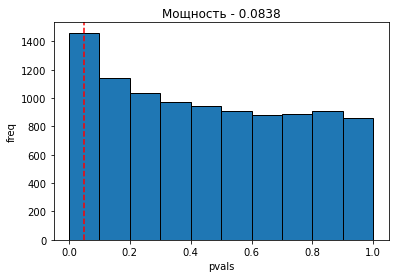

Время выполнения: 0:01:01.485724


In [252]:
a = np.random.normal(100, 20, size=1000)
b = np.random.normal(100, 20, size=1000)
check_mde = get_mde(a, b)

now = datetime.now()
pvals = [poisson_bootstrap(a=np.random.normal(100, 20, size=30),
                           b=np.random.normal(100 + check_mde, 20, size=30))
         for _ in tqdm(range(10000))]

plt.hist(pvals, edgecolor='black')
plt.xlabel('pvals')
plt.ylabel('freq')
plt.title(f'Мощность - {np.mean(np.array(pvals) < 0.05)}')
plt.axvline(0.05, linestyle='--', color='red')
plt.show()

after = datetime.now()
print(f'Время выполнения: {str(after - now)}')

# с мощностью всё в порядке, для нормального работает хорошо

__Посмотрим как распределяется значение mde при разных генерациях a и b (30 наблюдений)__

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'freq')

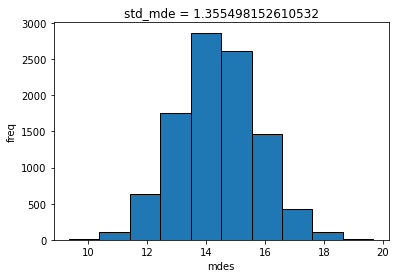

In [239]:
mdes = []
for i in tqdm(range(10000)):
    a = np.random.normal(100, 20, size=30)
    b = np.random.normal(100, 20, size=30)
    check_mde = get_mde(a, b)
    mdes.append(check_mde)
    
plt.hist(mdes, edgecolor = 'black')
plt.title(f'std_mde = {np.std(mdes)}')
plt.xlabel('mdes')
plt.ylabel('freq')


  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'freq')

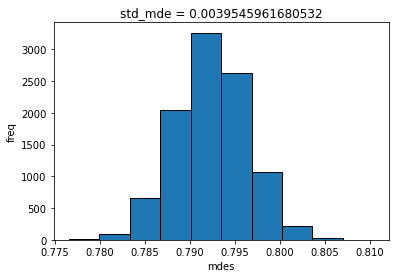

In [240]:
mdes = []
for i in tqdm(range(10000)):
    a = np.random.normal(100, 20, size=10000)
    b = np.random.normal(100, 20, size=10000)
    check_mde = get_mde(a, b)
    mdes.append(check_mde)
    
plt.hist(mdes, edgecolor = 'black')
plt.title(f'std_mde = {np.std(mdes)}')
plt.xlabel('mdes')
plt.ylabel('freq')


Мы получаем достаточно расплывчатое значение std, из-за чего не можем точно говорить про эффект, который должен быть при заданных **a**, **b** и др. Минимум дисперсии возможен при большой выборке, однако, мы не всегда можем себе гарантировать то, что в эксперименте будет участвовать достаточное количество наблюдений, которое влияет на разброс MDE.

__По сути__ 
* сумма квантильных функций - константа
* размеры выборки - константа
* остается, дисперсия, которая не обладает устойчивостью (выборка достаточно маленькая)

### Классический бутстрап  разницы средних (индексы)
1. Подвыборки индексов
2. Выбор объектов в выборке, которые соответствуют индексам
3. Разница средних
4. Дисперсия из разницы средних
5. Расчёт pvalue, как 1 - функция распределения, распределенная нормально (по ЦПТ, средние). Двусторонняя гипотеза - $ 2 * (1 - F_x) $ , где  $ F_x $ - функция распределения случайной величины 

In [241]:
def classic_bootstrap_index(a, b, num_experiments = 1000):
    num_experiments = 1000
    delta_means = []
    for exp in range(num_experiments):
        a_boots = np.random.choice(len(a), len(a), replace = True)
        b_boots = np.random.choice(len(b), len(b), replace = True)
        delta_mean = np.mean(b[b_boots]) - np.mean(a[a_boots])
        delta_means.append(delta_mean)

    std_delta_means = np.std(delta_means)
    true_delta = np.mean(b) - np.mean(a)
    return 2 * (1 - stats.norm.cdf(np.abs(true_delta / std_delta_means)))

# рассмотрим двухстороннюю гипотезу

  0%|          | 0/1000 [00:00<?, ?it/s]

Время выполнения: 0:02:33.142016


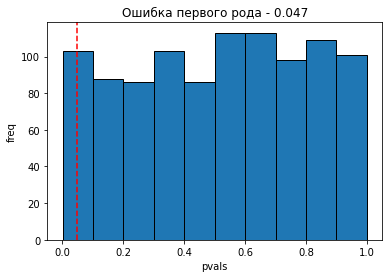

In [242]:
now = dt.now() 
pvals = [classic_bootstrap_index(a = np.random.normal(0,1, size = 1000), b = np.random.normal(0,1, size = 1000)) for i in tqdm(range(1000))]

plt.hist(pvals, edgecolor = 'black')
plt.xlabel('pvals')
plt.ylabel('freq')
plt.title(f'Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.axvline(0.05, linestyle = '--', color = 'red')

after = dt.now()

print(f'Время выполнения: {str(after - now)}')

# также небыстро, проверим границы применимости, когда ошибка первого рода фиксируется

In [248]:
get_mde(a = np.random.normal(100, 20, size = 1000), b=np.random.normal(100, 20, size=1000))
# 2.57 - MDE, после этого считаем, что дальше рассматриваем мощность , до этого - это ошибка первого рода

2.5724615827214303

0it [00:00, ?it/s]

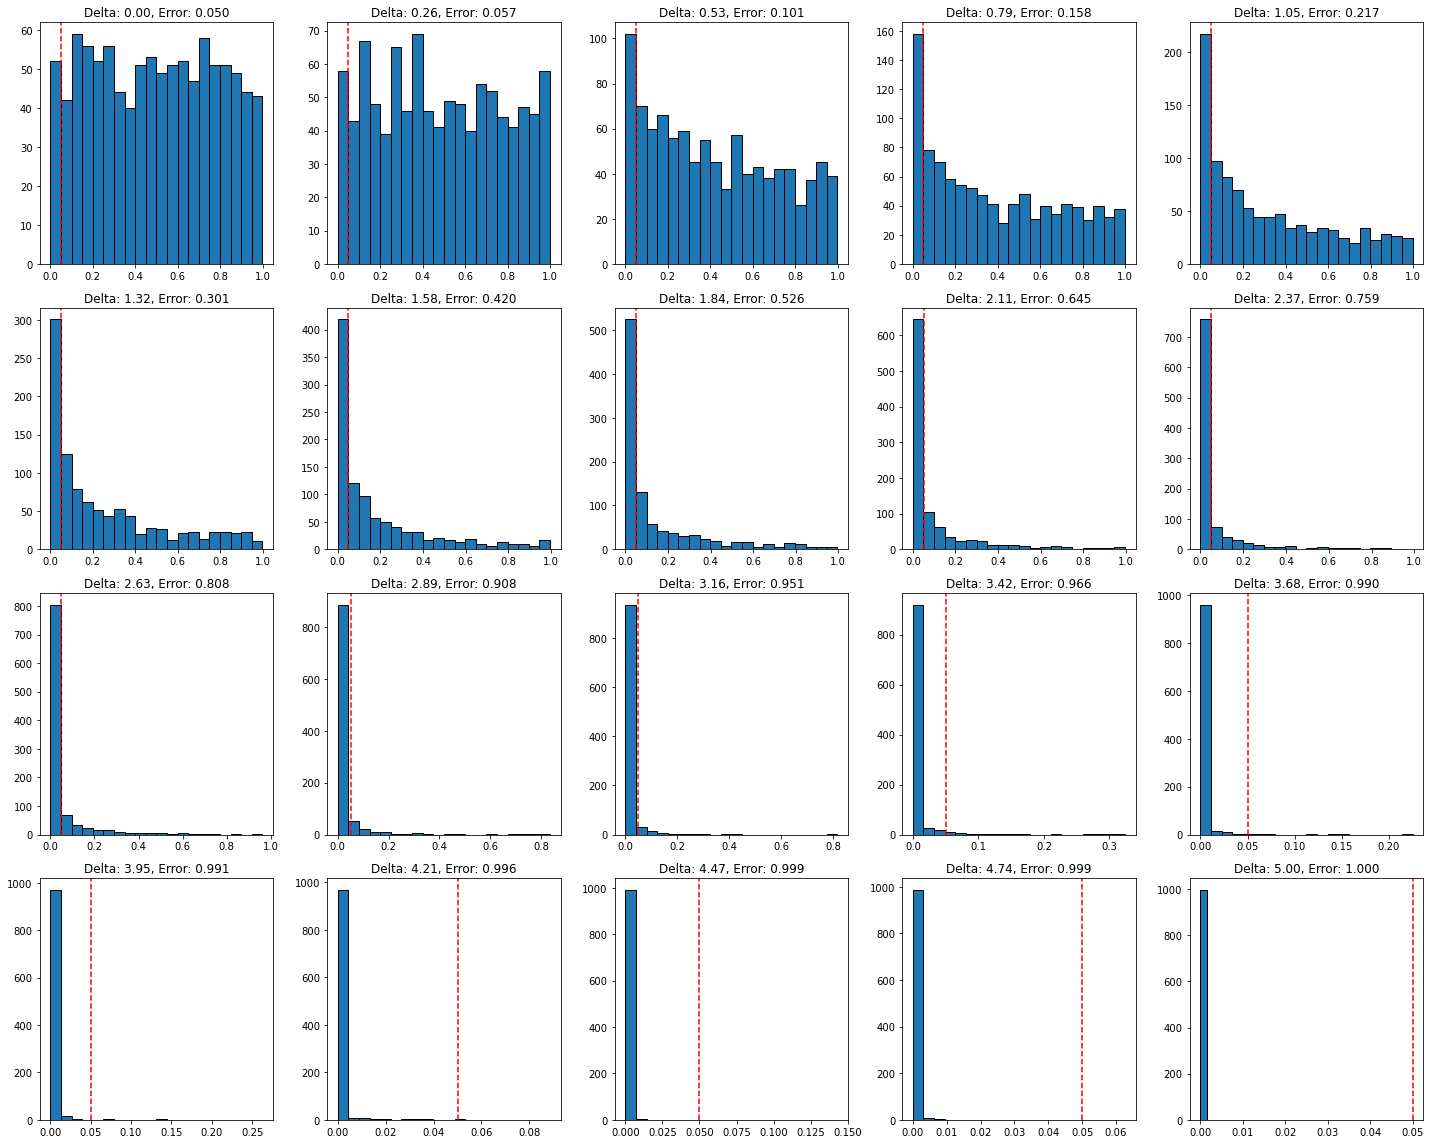

Время выполнения: 0:48:24.025298


In [244]:
num_experiments = 1000
num_graphs = 20
delta_values = np.linspace(0, 5, num_graphs)
now = dt.now() 

fig, axes = plt.subplots(4, 5, figsize=(20, 16))  
errors_first_type = []

for i, delta in tqdm(enumerate(delta_values)):
    pvals = [classic_bootstrap_index(a=np.random.normal(100, 20, size=1000),
                               b=np.random.normal(100 + delta, 20, size=1000))
             for _ in range(num_experiments)]
    errors_first_type.append(np.mean(np.array(pvals) < 0.05))
    
    ax = axes[i // 5, i % 5]
    ax.hist(pvals, bins=20, edgecolor='black')
    ax.set_title(f'Delta: {delta:.2f}, Error: {errors_first_type[-1]:.3f}')
    ax.axvline(0.05, linestyle='--', color='red')

plt.tight_layout()
plt.show()

after = dt.now()

print(f'Время выполнения: {after - now}')

# при сравнении с пуассоновским бутстрапом на одинаковом уровне delta получаем разные ошибки первого рода, на 2.63 - мощноть


1. По скорости нет различий, получаем для различных распределений
2. У бутстрапа есть проблема с тем, что на слишком маленьких выборках он выдает различные значения (из-за различий в дисперсии, стандартное отклонение у MDE значительно выше на маленькой выборке, что логично
3. Незначительные изменения в границах определения ошибки первого рода (при изменении лифта на одинаковых выборках). Например, пуассоновский бутстрап и реализация бутстрапа через индексы
4. Выбросы аффектят на бутстрап, конкретно на ошибку первого рода (из-за повышения дисперсии) и на второго рода (мощность всегда 1). Отсюда границы по дисперсии (не слишком большая).